- recent update: 24.11.5
- update content:
    1. timeseries SOTA TCN 모델 적용
    2. Input을 sequence 형태로 입력
- target var: mid price return class (class: 4)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
from tqdm import tqdm
import pickle
import os

In [3]:
# display max
#pd.set_option('display.max_rows', 90)
#pd.set_option('display.max_column', None)

In [4]:
# df = pd.read_csv('/content/drive/MyDrive/은성/data/df_processed_month3_1m5m_maxreturn.csv')

In [5]:
# # mid_price를 기반으로 한 수익률 컬럼 생성
# df['mid_price_return'] = df['mid_price'].pct_change() * 100
# #df['mid_price_return']

<ipython-input-5-f294a90d4d93>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['mid_price_return'] = df['mid_price'].pct_change() * 100


In [6]:

# # 필요한 데이터 분류 작업을 진행하기 위해 종속변수 기준 설정 및 분류 함수 정의

# # 분류 함수 정의 (논문 기준)
# def classify_return(value, threshold):
#     if value > threshold:
#         return 'Significant increase'
#     elif value < -threshold:
#         return 'Significant decrease'
#     elif 0 <= value <= threshold:
#         return 'Insignificant increase'
#     elif -threshold <= value < 0:
#         return 'Insignificant decrease'
#     else:
#         return 'Unknown'

# # 종속변수 '1_min_return_atbest'와 '5_min_return_atbest'에 대해 분류 수행
# df['mid_price_return_class'] = df['mid_price_return'].apply(lambda x: classify_return(x, threshold=0.002))

# # 분류된 데이터 확인
# df[['mid_price_return', 'mid_price_return_class']].head()


,mid_price_return,mid_price_return_class
0,NaN,Unknown
1,NaN,Unknown
2,NaN,Unknown
3,NaN,Unknown
4,NaN,Unknown


In [7]:
# # 변경 전 정보 출력
# print("Before cleaning:")
# print("Data shape:", df.shape)
# print("NaN counts per column:")
# print(df.isna().sum())

# # 숫자형 열만 선택하여 무한대 값 확인
# numeric_df = df.select_dtypes(include=[np.number])
# print("Infinite counts per column:")
# print(np.isinf(numeric_df).sum())

# # 특정 변수 제거
# df = df.drop(['1_min_return', '5_min_return'], axis=1)

# # na 및 무한대 값 제거
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)

# # 변경 후 정보 출력
# print("\nAfter cleaning:")
# print("Data shape:", df.shape)
# print("NaN counts per column:")
# print(df.isna().sum())
# print("Infinite counts per column:")
# print(np.isinf(df.select_dtypes(include=[np.number])).sum())


Before cleaning:
Data shape: (1904573, 89)
NaN counts per column:
false.2                         0
ask_price_1                     0
ask_price_10                    0
ask_price_11                    0
ask_price_12                    0
                           ...   
5_min_return              1904573
1_min_return_atbest           370
5_min_return_atbest           370
mid_price_return              119
mid_price_return_class          0
Length: 89, dtype: int64
Infinite counts per column:
ask_price_1            0
ask_price_10           0
ask_price_11           0
ask_price_12           0
ask_price_13           0
                      ..
1_min_return           0
5_min_return           0
1_min_return_atbest    0
5_min_return_atbest    0
mid_price_return       0
Length: 87, dtype: int64

After cleaning:
Data shape: (1904202, 87)
NaN counts per column:
false.2                      0
ask_price_1                  0
ask_price_10                 0
ask_price_11                 0
ask_price_12     

In [8]:
# # 종속변수 라벨을 2개의 클래스(0, 1)로 변환
# label_mapping = {'Significant increase': 0, 'Significant decrease': 1,
#                  'Insignificant increase': 2, 'Insignificant decrease': 3}

# # 종속변수 설정
# df['target_column'] = df['mid_price_return_class'].map(label_mapping)


In [16]:

# def split_data(data, train_ratio=0.7, val_ratio=0.15):
#     train_end = int(len(data) * train_ratio)
#     val_end = train_end + int(len(data) * val_ratio)

#     train_data = data[:train_end]
#     val_data = data[train_end:val_end]
#     test_data = data[val_end:]

#     return train_data, val_data, test_data

# def create_and_save_sequences(data, target_column, sequence_length, drop_cols, batch_size=10000, part_name="", output_dir="output"):

#     # target_column과 drop_cols를 제외한 feature_columns만 선택
#     feature_columns = data.columns.drop([target_column] + drop_cols)

#     # 열 개수 확인
#     print(f"Feature columns ({len(feature_columns)}):", feature_columns)

#     # StandardScaler 적용
#     scaler = StandardScaler()
#     data[feature_columns] = scaler.fit_transform(data[feature_columns])

#     sequences = []
#     targets = []

#     # 배치 단위로 시퀀스를 생성하여 tqdm으로 진행 상황 표시
#     for start in tqdm(range(0, len(data) - sequence_length, batch_size), desc=f"Generating sequences for {part_name}"):
#         end = min(start + batch_size, len(data) - sequence_length)

#         # 현재 배치 내에서 시퀀스 생성
#         batch_sequences = np.lib.stride_tricks.sliding_window_view(
#             data[feature_columns].values[start:end + sequence_length],
#             window_shape=(sequence_length, len(feature_columns))
#         )
#         batch_targets = data[target_column].values[start + sequence_length:end + sequence_length]

#         sequences.append(batch_sequences)
#         targets.append(batch_targets)

#     # 모든 배치를 합쳐 최종 시퀀스 및 타겟 배열 생성
#     sequences = np.concatenate(sequences, axis=0)
#     targets = np.concatenate(targets, axis=0)

#     # sequences와 targets의 개수 맞추기
#     min_length = min(len(sequences), len(targets))
#     sequences = sequences[:min_length]
#     targets = targets[:min_length]

#     # Torch 텐서로 변환
#     sequences = torch.tensor(sequences, dtype=torch.float32)
#     targets = torch.tensor(targets, dtype=torch.long)

#     # 지정한 디렉토리에 저장 경로 설정
#     os.makedirs(output_dir, exist_ok=True)
#     sequences_path = os.path.join(output_dir, f"{part_name}_sequences.pkl")
#     targets_path = os.path.join(output_dir, f"{part_name}_targets.pkl")

#     # 결과를 pickle로 저장
#     with open(sequences_path, "wb") as f:
#         pickle.dump(sequences, f)
#     with open(targets_path, "wb") as f:
#         pickle.dump(targets, f)

#     print(f"Saved {part_name} data: sequences.shape={sequences.shape}, targets.shape={targets.shape}")

#     return scaler

# # 데이터 분할
# sequence_length = 10
# target_column = 'target_column'

# # 제외할 열들
# drop_cols = ['false.2', '1_min_return_atbest', '5_min_return_atbest', 'mid_price', 'mid_price_diff', 'mid_price_return', 'mid_price_return_class']
# train_data, val_data, test_data = split_data(df)

# # 데이터를 절반으로 나누기
# train_data_1 = train_data[:len(train_data) // 2]
# train_data_2 = train_data[len(train_data) // 2:]

# # 저장할 디렉토리 지정
# output_dir = "/content/drive/MyDrive/은성/data"  # 원하는 경로로 수정

# # 각각의 절반에 대해 시퀀스 생성 및 저장
# scaler_1 = create_and_save_sequences(train_data_1, target_column, sequence_length, drop_cols, batch_size=10000, part_name="train_part1", output_dir=output_dir)
# scaler_2 = create_and_save_sequences(train_data_2, target_column, sequence_length, drop_cols, batch_size=10000, part_name="train_part2", output_dir=output_dir)

# # Validation 및 Test 데이터도 동일한 방식으로 저장
# create_and_save_sequences(val_data, target_column, sequence_length, drop_cols, batch_size=10000, part_name="val", output_dir=output_dir)
# create_and_save_sequences(test_data, target_column, sequence_length, drop_cols, batch_size=10000, part_name="test", output_dir=output_dir)



Feature columns (80): Index(['ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12',
       'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2',
       'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6',
       'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1',
       'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13',
       'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4',
       'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9',
       'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12',
       'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2',
       'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6',
       'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1',
       'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13',
       'bid_size_14', 'bid_size_15', 'bid_size_2', 'bid_size_3', 'bid_size_4',
       'bid_size_5', 'bid_size_6', 'bid_size_7', 'bid_size_8', 

<ipython-input-16-e67e7be31afb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_columns] = scaler.fit_transform(data[feature_columns])
Generating sequences for train_part1: 100%|██████████| 67/67 [00:26<00:00,  2.49it/s]


Saved train_part1 data: sequences.shape=torch.Size([666460, 1, 10, 80]), targets.shape=torch.Size([666460])
Feature columns (80): Index(['ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12',
       'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2',
       'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6',
       'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1',
       'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13',
       'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4',
       'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9',
       'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12',
       'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2',
       'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6',
       'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1',
       'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13',
       'bid_size_14', 'bid_size_15

<ipython-input-16-e67e7be31afb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_columns] = scaler.fit_transform(data[feature_columns])
Generating sequences for train_part2: 100%|██████████| 67/67 [00:28<00:00,  2.31it/s]


Saved train_part2 data: sequences.shape=torch.Size([666461, 1, 10, 80]), targets.shape=torch.Size([666461])
Feature columns (80): Index(['ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12',
       'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2',
       'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6',
       'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1',
       'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13',
       'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4',
       'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9',
       'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12',
       'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2',
       'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6',
       'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1',
       'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13',
       'bid_size_14', 'bid_size_15

<ipython-input-16-e67e7be31afb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_columns] = scaler.fit_transform(data[feature_columns])
Generating sequences for val: 100%|██████████| 29/29 [00:06<00:00,  4.53it/s]


Saved val data: sequences.shape=torch.Size([285620, 1, 10, 80]), targets.shape=torch.Size([285620])
Feature columns (80): Index(['ask_price_1', 'ask_price_10', 'ask_price_11', 'ask_price_12',
       'ask_price_13', 'ask_price_14', 'ask_price_15', 'ask_price_2',
       'ask_price_3', 'ask_price_4', 'ask_price_5', 'ask_price_6',
       'ask_price_7', 'ask_price_8', 'ask_price_9', 'ask_size_1',
       'ask_size_10', 'ask_size_11', 'ask_size_12', 'ask_size_13',
       'ask_size_14', 'ask_size_15', 'ask_size_2', 'ask_size_3', 'ask_size_4',
       'ask_size_5', 'ask_size_6', 'ask_size_7', 'ask_size_8', 'ask_size_9',
       'bid_price_1', 'bid_price_10', 'bid_price_11', 'bid_price_12',
       'bid_price_13', 'bid_price_14', 'bid_price_15', 'bid_price_2',
       'bid_price_3', 'bid_price_4', 'bid_price_5', 'bid_price_6',
       'bid_price_7', 'bid_price_8', 'bid_price_9', 'bid_size_1',
       'bid_size_10', 'bid_size_11', 'bid_size_12', 'bid_size_13',
       'bid_size_14', 'bid_size_15', 'bid_

<ipython-input-16-e67e7be31afb>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature_columns] = scaler.fit_transform(data[feature_columns])
Generating sequences for test: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s]


Saved test data: sequences.shape=torch.Size([285621, 1, 10, 80]), targets.shape=torch.Size([285621])


StandardScaler()

In [17]:
# 저장된 pickle 파일들을 불러와 텐서를 결합하는 함수
def load_and_concatenate_tensors(file_paths):
    tensors = []
    for file_path in file_paths:
        with open(file_path, 'rb') as f:
            tensor = pickle.load(f)
            tensors.append(tensor)
    # 텐서 리스트를 하나로 결합
    return torch.cat(tensors, dim=0)

# 파일 경로 지정
output_dir = "/content/drive/MyDrive/은성/data"
train_sequence_files = [os.path.join(output_dir, "train_part1_sequences.pkl"),
                        os.path.join(output_dir, "train_part2_sequences.pkl")]
train_target_files = [os.path.join(output_dir, "train_part1_targets.pkl"),
                      os.path.join(output_dir, "train_part2_targets.pkl")]

# 각 파일을 불러와 결합
train_sequences = load_and_concatenate_tensors(train_sequence_files)
train_targets = load_and_concatenate_tensors(train_target_files)

# 검증 및 테스트 데이터도 동일한 방식으로 로드
val_sequences = load_and_concatenate_tensors([os.path.join(output_dir, "val_sequences.pkl")])
val_targets = load_and_concatenate_tensors([os.path.join(output_dir, "val_targets.pkl")])
test_sequences = load_and_concatenate_tensors([os.path.join(output_dir, "test_sequences.pkl")])
test_targets = load_and_concatenate_tensors([os.path.join(output_dir, "test_targets.pkl")])

# 결과 확인
print("Train Sequences shape:", train_sequences.shape)
print("Train Targets shape:", train_targets.shape)
print("Validation Sequences shape:", val_sequences.shape)
print("Validation Targets shape:", val_targets.shape)
print("Test Sequences shape:", test_sequences.shape)
print("Test Targets shape:", test_targets.shape)


Train Sequences shape: torch.Size([1332921, 1, 10, 80])
Train Targets shape: torch.Size([1332921])
Validation Sequences shape: torch.Size([285620, 1, 10, 80])
Validation Targets shape: torch.Size([285620])
Test Sequences shape: torch.Size([285621, 1, 10, 80])
Test Targets shape: torch.Size([285621])


### TCN 모델

In [19]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout):
        super(TemporalBlock, self).__init__()

        # Causal Padding을 위한 padding 설정
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        # 패딩으로 인해 발생한 여분의 시계열 길이 제거
        out = out[:, :, :x.size(2)]
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()

        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        out = self.network(x)
        out = out[:, :, -1]  # 마지막 시점의 출력을 사용
        return self.linear(out)


In [24]:
# GPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [32]:
# 모델 하이퍼파라미터 설정
input_size = 80        # 입력 특징 수
output_size = 4        # 출력 클래스 수 (4중 분류)
num_channels = [64, 128, 256]  # TCN 채널 크기
kernel_size = 3        # 커널 크기
dropout = 0.2          # 드롭아웃 비율
learning_rate = 0.0001
num_epochs = 40

# 모델 저장 경로 설정
save_path = "/content/drive/MyDrive/은성/best_model.pth"

# 모델 초기화 및 GPU 이동
model = TCN(input_size, output_size, num_channels, kernel_size, dropout).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 및 검증 손실 저장용 리스트
train_losses = []
val_losses = []
best_val_loss = float("inf")  # 최저 검증 손실 초기화

# 시퀀스 데이터의 차원을 (배치 크기, 시퀀스 길이, 특징 수)로 변환하고 GPU로 이동
train_sequences = train_sequences.squeeze(1).permute(0, 2, 1).to(device)  # (batch_size, feature_size, sequence_length)
val_sequences = val_sequences.squeeze(1).permute(0, 2, 1).to(device)
test_sequences = test_sequences.squeeze(1).permute(0, 2, 1).to(device)
train_targets = train_targets.to(device)
val_targets = val_targets.to(device)
test_targets = test_targets.to(device)


# 학습 및 검증 데이터 로더 생성
batch_size = 64
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_sequences, train_targets), batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_sequences, val_targets), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_sequences, test_targets), batch_size=batch_size, shuffle=False)

# 모델 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path):
    global best_val_loss
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 데이터 GPU로 이동
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # 평균 학습 손실 계산
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # 데이터 GPU로 이동
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 평균 검증 손실 계산
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # 검증 손실이 가장 낮은 경우 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss improved to {val_loss:.4f}. Model saved.")

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# 모델 학습
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_path)

# 학습 및 검증 손실 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


Epoch [1/40], Validation Loss improved to 0.7338. Model saved.
Epoch [1/40], Train Loss: 0.5494, Validation Loss: 0.7338
Epoch [2/40], Validation Loss improved to 0.7210. Model saved.
Epoch [2/40], Train Loss: 0.5452, Validation Loss: 0.7210
Epoch [3/40], Validation Loss improved to 0.7149. Model saved.
Epoch [3/40], Train Loss: 0.5442, Validation Loss: 0.7149
Epoch [4/40], Train Loss: 0.5437, Validation Loss: 0.7189
Epoch [5/40], Train Loss: 0.5432, Validation Loss: 0.7198
Epoch [6/40], Train Loss: 0.5427, Validation Loss: 0.7192
Epoch [7/40], Train Loss: 0.5422, Validation Loss: 0.7155
Epoch [8/40], Train Loss: 0.5418, Validation Loss: 0.7152
Epoch [9/40], Train Loss: 0.5413, Validation Loss: 0.7165
Epoch [10/40], Train Loss: 0.5408, Validation Loss: 0.7171
Epoch [11/40], Train Loss: 0.5404, Validation Loss: 0.7198
Epoch [12/40], Train Loss: 0.5400, Validation Loss: 0.7206
Epoch [13/40], Train Loss: 0.5395, Validation Loss: 0.7209
Epoch [14/40], Train Loss: 0.5389, Validation Loss: 0

KeyboardInterrupt: 

<ipython-input-33-9c54b0759809>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드


                        precision    recall  f1-score   support

  Significant increase       0.00      0.00      0.00     17050
  Significant decrease       0.00      0.00      0.00     16631
Insignificant increase       0.83      1.00      0.91    236647
Insignificant decrease       0.00      0.00      0.00     15293

              accuracy                           0.83    285621
             macro avg       0.21      0.25      0.23    285621
          weighted avg       0.69      0.83      0.75    285621

Accuracy: 0.8285


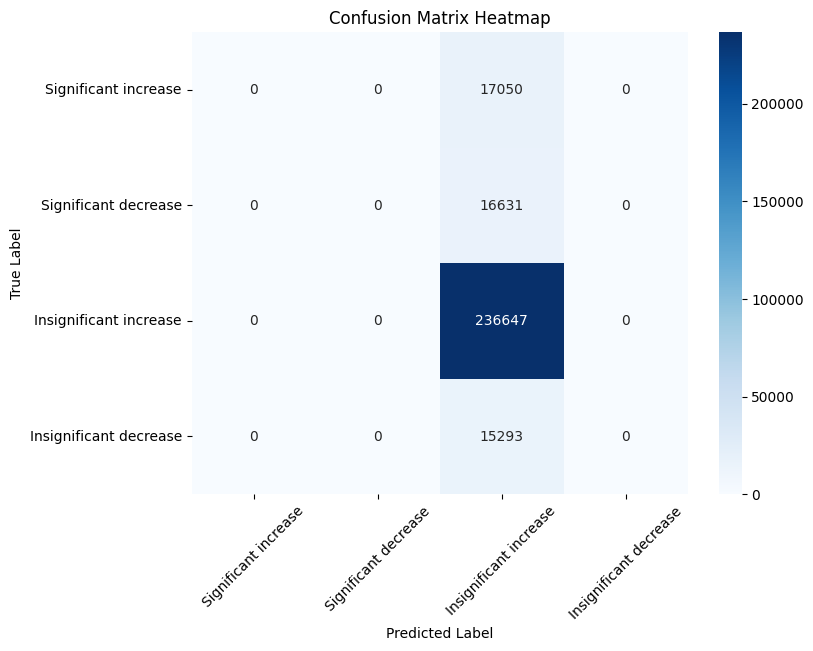

In [33]:
# 모델 저장 경로 설정
best_model_path = "/content/drive/MyDrive/은성/best_model.pth"

# 베스트 모델 로드 및 테스트 데이터에서 예측 수행
# 모델 초기화 및 저장된 베스트 모델 로드
best_model = TCN(input_size, output_size, num_channels, kernel_size, dropout).to(device)
best_model.load_state_dict(torch.load(best_model_path))  # 저장된 베스트 모델 로드
best_model.eval()  # 평가 모드로 전환

# 테스트 데이터에서 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:  # test_loader는 테스트 데이터를 위한 DataLoader입니다.
        features, labels = features.to(device), labels.to(device)
        outputs = best_model(features)
        _, preds = torch.max(outputs, 1)  # 예측 클래스 선택

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. 분류 성능 보고서 출력 (정확도, 정밀도, 재현율, F1 스코어)
labels_set = [0, 1, 2, 3]  # 4개의 레이블
target_names = ['Significant increase', 'Significant decrease', 'Insignificant increase', 'Insignificant decrease']

# Classification report 출력
report = classification_report(all_labels, all_preds, labels=labels_set, target_names=target_names, zero_division=0)
print(report)

# Accuracy 계산 및 출력
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

# 2. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds, labels=labels_set)

# 혼동 행렬 히트맵 시각화 (x축 값 45도 회전)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xticks(rotation=45)  # x축 라벨 45도 회전
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

- Precision (정밀도):

정밀도는 모델이 해당 클래스로 예측한 값 중 실제로 맞은 비율입니다.
예를 들어, "Significant increase" 클래스에 대해 모델이 98%의 정밀도를 보였다는 것은, 모델이 이 클래스로 예측한 값 중 98%가 실제로 맞았다는 의미입니다.
하지만 "Significant decrease" 클래스는 데이터에 등장하지 않아서 정밀도가 0.00으로 표시되었습니다.

- Recall (재현율):

재현율은 실제로 해당 클래스에 속한 데이터 중에서 모델이 올바르게 예측한 비율입니다.
예를 들어, "Insignificant increase" 클래스에 대한 재현율이 0.92라는 것은, 실제로 "Insignificant increase"에 속한 데이터 중 92%를 모델이 정확히 맞췄다는 의미입니다.
"Significant increase" 클래스의 재현율이 0.01이라는 것은, 이 클래스에 속한 실제 데이터 중 1%만 모델이 맞췄다는 의미입니다.

- F1-score:

F1 스코어는 정밀도와 재현율의 조화평균으로, 두 지표를 종합적으로 평가하는 지표입니다. 정밀도와 재현율 사이의 균형을 중요시할 때 유용합니다.
예를 들어, "Insignificant increase" 클래스의 F1 스코어가 0.84라는 것은, 정밀도와 재현율이 적절히 균형을 이뤘음을 의미합니다.

- Support:

Support는 각 클래스에 실제로 속한 데이터의 개수입니다.
예를 들어, "Insignificant increase" 클래스는 241,234개의 데이터 포인트를 가지고 있다는 것을 의미합니다.

- Micro avg (마이크로 평균):

마이크로 평균은 전체 데이터에서의 정밀도, 재현율, F1 스코어를 계산합니다. 이는 각 클래스의 데이터 개수를 고려하지 않고, 전체 데이터를 한 번에 평가하는 방식입니다.
마이크로 평균 77%는 모든 클래스의 데이터를 합쳐서 모델이 77%의 정확도를 보였음을 의미합니다.

- Macro avg (매크로 평균):

매크로 평균은 각 클래스의 정밀도, 재현율, F1 스코어의 평균을 단순히 계산한 것입니다. 이는 클래스별 데이터 비율을 고려하지 않기 때문에, 클래스 간 불균형이 있는 경우 잘못된 평가가 나올 수 있습니다.
예를 들어, "Significant decrease" 클래스처럼 데이터가 없는 클래스는 성능이 0으로 평가되며, 이러한 클래스들도 평균에 포함되기 때문에 성능이 낮아집니다.

- Weighted avg (가중 평균):

가중 평균은 각 클래스의 정밀도, 재현율, F1 스코어를 해당 클래스의 데이터 개수에 비례하여 평균을 계산한 것입니다. 즉, 클래스의 데이터가 많을수록 해당 클래스의 성능이 평균에 더 큰 영향을 줍니다.
Weighted 평균 77%는 실제 데이터 비율에 따라 가중치를 부여하여 계산한 성능입니다. 이 값은 전체적으로 모델이 77%의 정확도를 가지고 있음을 보여줍니다.

`WeightedRandomSampler`는 PyTorch에서 데이터 불균형 문제를 해결하기 위해 사용되는 샘플링 기법입니다. 데이터셋에서 각 샘플에 가중치를 부여하고, 가중치에 따라 샘플이 선택될 확률을 조정하여 데이터 로더에서 데이터를 균형 있게 제공하는 역할을 합니다.

#### 기본 원리:
- 각 클래스의 샘플 수가 불균형한 경우, `WeightedRandomSampler`는 각 샘플에 가중치를 부여합니다.
- 가중치가 큰 클래스의 샘플은 더 자주 선택되고, 가중치가 작은 클래스의 샘플은 덜 자주 선택됩니다.
- 이렇게 함으로써 모델이 훈련할 때, 각 클래스가 데이터셋에서 고르게 학습되도록 하여 __클래스 불균형 문제__를 완화할 수 있습니다.

#### 주요 파라미터:
- `weights`: 각 샘플에 부여되는 가중치입니다. 이 값은 클래스의 빈도에 반비례하여 설정되는 경우가 많습니다. 즉, 샘플 수가 적은 클래스에 더 큰 가중치를 부여하여 학습 시 자주 선택되도록 합니다.
- `num_samples`: 각 epoch에서 샘플링할 총 샘플 수를 나타냅니다. 일반적으로는 전체 샘플 수와 같게 설정합니다.
- `replacement`: `True`로 설정하면 샘플이 복원(replacement)되어 샘플링됩니다. 즉, 같은 샘플이 여러 번 선택될 수 있습니다.